In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

import numpy as np
import jax
import jax.numpy as jnp
from temgym_core.components import Detector, Lens, Biprism
from temgym_core.gaussian import make_gaussian_image, GaussianRay, evaluate_gaussian_input_image
from temgym_core.source import ParallelBeam
from temgym_core.ray import Ray
from temgym_core.utils import fibonacci_spiral, custom_jacobian_matrix
from temgym_core.run import run_to_end, run_iter
from temgym_core.plotting import plot_model, PlotParams, plot_ray_bundle, _stack_ray_positions
from typing import Sequence, Tuple

%matplotlib widget
import matplotlib.pyplot as plt

In [24]:
aperture_window_width = 0.5e-6  # 0.5 um aperture window width
num_aper_pixels = 128
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 100e-9  # 100 nm aperture radius

num_beams = int(1e6)
r1x, r1y = fibonacci_spiral(nb_samples=num_beams, radius=aperture_radius, alpha=0)

wavelength = 2e-12  # 2 pm wavelength
k = 2 * np.pi / wavelength
wo = 5e-10

#area of aperture
aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

In [25]:

# Gaussian Beam Input
xs = r1x
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [26]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [27]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=100)

extent = [input_aperture_grid.coords_1d[0][0], input_aperture_grid.coords_1d[0][-1], input_aperture_grid.coords_1d[1][0], input_aperture_grid.coords_1d[1][-1]]

Text(0.5, 1.0, 'Aperture Plane Amplitude')

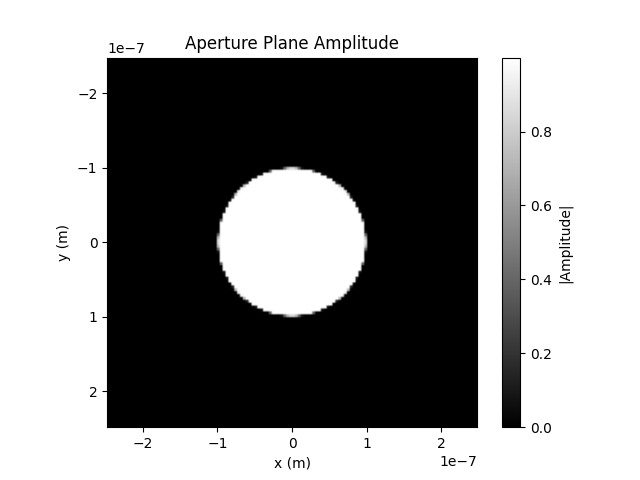

In [28]:
plt.figure()
plt.imshow(jnp.abs(aperture_image), cmap='gray', extent=extent)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.colorbar(label='|Amplitude|')
plt.title('Aperture Plane Amplitude')

In [35]:
M1 = -100
F1 = 2.5e-3
M2 = -1000
F2 = 1e-3

defocus = 1e-5
L1_z1 = F1 * (1/M1 - 1)
L1_z2 = F1 * (1 - M1)
L2_z1 = F2 * (1/M2 - 1)
L2_z2 = F2 * (1 - M2)

print(L1_z1, L1_z2, L2_z1, L2_z2)

input_beam = ParallelBeam(z=0.0 + defocus, radius=aperture_radius)
Lens1 = Lens(focal_length=F1, z=abs(L1_z1))
biprism = Biprism(z=abs(L1_z1) + abs(L1_z2) / 2, rotation = 0.0, deflection = -3e-5)
Lens2 = Lens(focal_length=F2, z=abs(L1_z1) + abs(L1_z2) + abs(L2_z1))
detector = Detector(z=abs(L1_z1) + abs(L1_z2) + abs(L2_z1) + abs(L2_z2), pixel_size=(440e-6, 440e-6), shape=(64, 64))
model = [
    input_beam,
    Lens1,
    biprism,
    Lens2,
    detector,
]

-0.002525 0.2525 -0.001001 1.0010000000000001


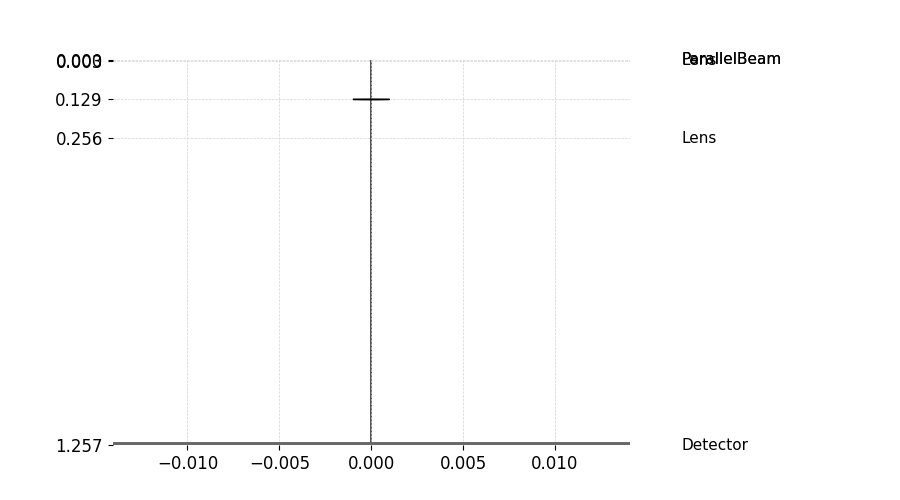

In [36]:

central_ray = Ray(x=0., y=0.0, dx=0.0, dy=0.0, z=input_beam.z, pathlength=0.0, _one=1.0)
central_ray = central_ray.to_vector()
out_ray = run_to_end(central_ray, model)

ABCD = jax.jacobian(lambda r: run_to_end(r, model))(central_ray)
ABCD = custom_jacobian_matrix(ABCD)
ABCD[0, 0, :, :]

plot_params = PlotParams(ray_color='k', extent_scale = 1.2, lens_height=1e-6)
fig, ax = plot_model(model, rays = central_ray, plot_params=plot_params)

In [37]:
left_rays_indices = xs < 0.0
left_rays = GaussianRay(
    x=xs[left_rays_indices], 
    y=ys[left_rays_indices], 
    dx=dxs[left_rays_indices],
    dy=dys[left_rays_indices], 
    z=jnp.ones_like(xs[left_rays_indices]) * input_beam.z,
    pathlength=pathlengths[left_rays_indices], 
    _one=ones[left_rays_indices], 
    amplitude=amplitudes[left_rays_indices], 
    waist_xy=waist_xy[left_rays_indices],
    radii_of_curv=radii_of_curv[left_rays_indices],
    wavelength=wavelengths[left_rays_indices], 
    theta=theta[left_rays_indices],
)

right_rays_indices = xs >= 0.0
right_rays = GaussianRay(
    x=xs[right_rays_indices],
    y=ys[right_rays_indices],
    dx=dxs[right_rays_indices],
    dy=dys[right_rays_indices],
    z=jnp.ones_like(xs[right_rays_indices]) * input_beam.z,
    pathlength=pathlengths[right_rays_indices],
    _one=ones[right_rays_indices],
    amplitude=amplitudes[right_rays_indices],
    waist_xy=waist_xy[right_rays_indices],
    radii_of_curv=radii_of_curv[right_rays_indices],
    wavelength=wavelengths[right_rays_indices],
    theta=theta[right_rays_indices],
)

det_image_left = make_gaussian_image(left_rays, model, batch_size=500)
det_image_right = make_gaussian_image(right_rays, model, batch_size=500)
det_image = det_image_left + det_image_right

In [38]:
left_rays = left_rays.to_ray()
right_rays = right_rays.to_ray()
out_rays_left = run_to_end(left_rays, model)
out_rays_right = run_to_end(right_rays, model)

# # Accumulate rays after each step (including propagations)
# steps: list[Tuple[object, Ray]] = list(run_iter(left_rays, model))
# X, Z = _stack_ray_positions(steps)
# plot_params = PlotParams(ray_color='b')
# plot_ray_bundle(ax, X[:, 0::1000], Z, plot_params, band_mode='lines')

# steps: list[Tuple[object, Ray]] = list(run_iter(right_rays, model))
# X, Z = _stack_ray_positions(steps)
# plot_params = PlotParams(ray_color='g')
# plot_ray_bundle(ax, X[:, 0::1000], Z, plot_params, band_mode='lines')

# plt.show()

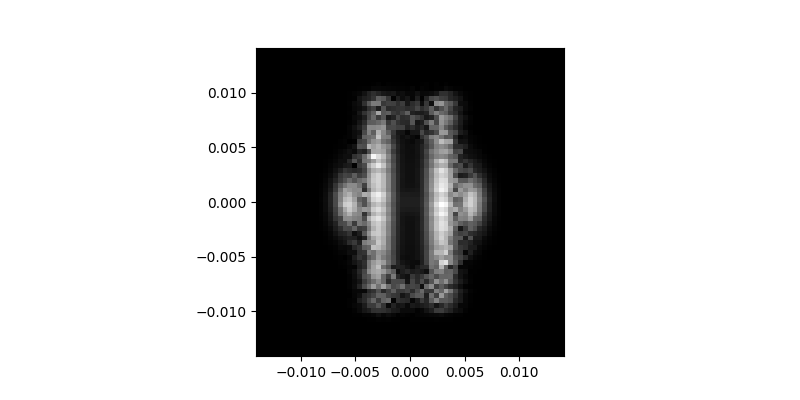

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
img = np.abs(det_image)

# ax.plot(out_rays_left.x, out_rays_left.y, 'r.', markersize=1, alpha=0.1)
# ax.plot(out_rays_right.x, out_rays_right.y, 'g.', markersize=1, alpha=0.1)
ax.imshow(img, cmap="gray", extent=[-detector.pixel_size[0]*detector.shape[0]/2, detector.pixel_size[0]*detector.shape[0]/2, -detector.pixel_size[1]*detector.shape[1]/2, detector.pixel_size[1]*detector.shape[1]/2])